In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

import sys

sys.path.insert(0, './code')
import dataloader
import trainer
import numpy as np
from sklearn.model_selection import KFold


In [2]:
import importlib

loader = dataloader.DataLoader()
importlib.reload(trainer)
stack_handler = trainer.StackTrainHandler()

Start Loading idx info
Fetch idx_result from 2021_12_20_idx_results.joblib
Start Loading ylabels info
Fetch ylabel infos from 2021_12_20_stack_labels.joblib


In [3]:
stack_handler.get()

Start transform the base model results into ltr feats
Start trans model amt_1 from 2021_12_20_amt_train_results.joblib
Start trans model cnt_1 from 2021_12_20_cnt_train_results.joblib
Start trans model amt_2 from 2021_12_19_amt_cnt_train_results.joblib
Start trans model cnt_2 from 2021_12_22_amt_cnt_train_results.joblib
Start trans model cnt_v_1 from 2021_12_24_cnt_v_train_results.joblib
Start trans model cnt_poisson_1 from 2021_12_27_cnt_poisson_train_results.joblib
Start trans model amt_tweedie from 2021_12_27_amt_cnt_train_results.joblib
Start trans model amt_start_dt from 2022_01_04_start_dt_amt_train_results.joblib
Start trans model cnt_v_2 from 2022_01_05_cnt_v_train_results.joblib
Start merge the base model feats
['amt_1', 'cnt_1', 'amt_2', 'cnt_2', 'cnt_v_1', 'cnt_poisson_1', 'amt_tweedie', 'amt_start_dt', 'cnt_v_2']


In [4]:
use_cols = ["pred_{}".format(model_name) for model_name in stack_handler.config['base_model_names']]

In [5]:
# rank_cols = ["rank_{}".format(dt)]
rank_feats = loader.load_result("2021_12_26_rank_feats.joblib")

In [6]:
# generate dt = 23
rank_feats_23 = rank_feats[['chid', 'shop_tag'] +
                           ["rank_{}".format(dt) for dt in range(1, 23)]]
rank_feats_23['dt'] = 23
rank_feats_23['query_id'] = rank_feats_23['chid'].apply(
    lambda x: str(x)) + rank_feats_23['dt'].apply(lambda x: str(x))
rank_feats_23 = rank_feats_23[['query_id', 'shop_tag'] +
                              ["rank_{}".format(dt) for dt in range(1, 23)]]
rank_feats_23.columns = ['query_id', 'shop_tag'] + [
    "rank_{}".format(dt - 23) for dt in range(1, 23)
]

# generate dt = 24
rank_feats_24 = rank_feats[['chid', 'shop_tag'] +
                           ["rank_{}".format(dt) for dt in range(2, 24)]]
rank_feats_24['dt'] = 24
rank_feats_24['query_id'] = rank_feats_24['chid'].apply(
    lambda x: str(x)) + rank_feats_24['dt'].apply(lambda x: str(x))
rank_feats_24 = rank_feats_24[['query_id', 'shop_tag'] +
                              ["rank_{}".format(dt) for dt in range(2, 24)]]
rank_feats_24.columns = ['query_id', 'shop_tag'] + [
    "rank_{}".format(dt - 24) for dt in range(2, 24)
]

# generate dt = 25
rank_feats_test = rank_feats[['chid', 'shop_tag'] +
                             ["rank_{}".format(dt) for dt in range(3, 25)]]
rank_feats_test['dt'] = 25
rank_feats_test['query_id'] = rank_feats_test['chid'].apply(
    lambda x: str(x)) + rank_feats_test['dt'].apply(lambda x: str(x))
rank_feats_test = rank_feats_test[
    ['query_id', 'shop_tag'] + ["rank_{}".format(dt) for dt in range(3, 25)]]
rank_feats_test.columns = ['query_id', 'shop_tag'] + [
    "rank_{}".format(dt - 25) for dt in range(3, 25)
]


/var/folders/tg/blfz3_nx7mv1lyzw21lksk3w0000gn/T/ipykernel_69195/1388370111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_feats_23['dt'] = 23
/var/folders/tg/blfz3_nx7mv1lyzw21lksk3w0000gn/T/ipykernel_69195/1388370111.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_feats_24['dt'] = 24
/var/folders/tg/blfz3_nx7mv1lyzw21lksk3w0000gn/T/ipykernel_69195/1388370111.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [7]:
rank_cols = ["rank_{}".format(dt-23) for dt in range(1, 23)]
rank_train = pd.concat([rank_feats_23, rank_feats_24]).reset_index(drop=True)
rank_test = rank_feats_test

In [8]:
amt_train, amt_test = loader.load_result('2021_12_27_freq_buy.joblib')
amt_train = amt_train.drop('start_dt', axis=1)
amt_test = amt_test.drop('start_dt', axis=1)

In [9]:
freq_cols = list(amt_train.columns[2:])

In [10]:
# amt_train['start_dt'] = amt_train['start_dt'].apply(lambda x: 23 +int(x))
# amt_test['start_dt'] = amt_test['start_dt'].apply(lambda x: 23 + int(x))


In [11]:
# miss_ids = loader.load_result('2021_12_26_miss_ids.joblib')

Training fold 1


/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5365
[LightGBM] [Info] Number of data points in the train set: 3555562, number of used features: 46


/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@3: 0.841935	valid_1's ndcg@3: 0.928748
[100]	training's ndcg@3: 0.844342	valid_1's ndcg@3: 0.92904
[150]	training's ndcg@3: 0.84623	valid_1's ndcg@3: 0.929089
Early stopping, best iteration is:
[117]	training's ndcg@3: 0.844998	valid_1's ndcg@3: 0.929117


<Figure size 864x432 with 0 Axes>

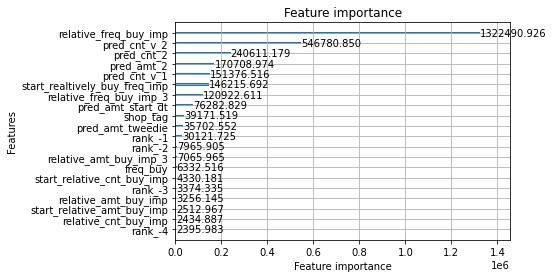

Training fold 2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.188025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5368
[LightGBM] [Info] Number of data points in the train set: 3555563, number of used features: 46
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@3: 0.842736	valid_1's ndcg@3: 0.928
[100]	training's ndcg@3: 0.845222	valid_1's ndcg@3: 0.928367
[150]	training's ndcg@3: 0.847022	valid_1's ndcg@3: 0.928453
[200]	training's ndcg@3: 0.848514	valid_1's ndcg@3: 0.928426
Early stopping, best iteration is:
[178]	training's ndcg@3: 0.847889	valid_1's ndcg@3: 0.928482


<Figure size 864x432 with 0 Axes>

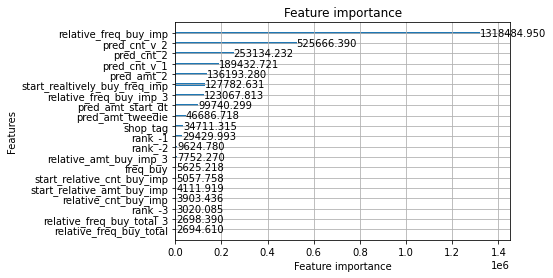

Training fold 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5365
[LightGBM] [Info] Number of data points in the train set: 3555563, number of used features: 46
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@3: 0.841486	valid_1's ndcg@3: 0.929166
[100]	training's ndcg@3: 0.844046	valid_1's ndcg@3: 0.929396
[150]	training's ndcg@3: 0.845909	valid_1's ndcg@3: 0.92939
Early stopping, best iteration is:
[124]	training's ndcg@3: 0.844978	valid_1's ndcg@3: 0.929487


<Figure size 864x432 with 0 Axes>

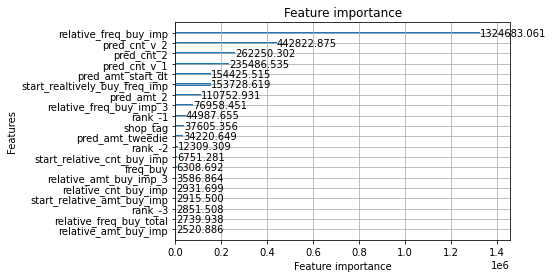

Training fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5364
[LightGBM] [Info] Number of data points in the train set: 3555552, number of used features: 46
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@3: 0.842119	valid_1's ndcg@3: 0.929146
[100]	training's ndcg@3: 0.844504	valid_1's ndcg@3: 0.929414
[150]	training's ndcg@3: 0.846279	valid_1's ndcg@3: 0.929465
[200]	training's ndcg@3: 0.847805	valid_1's ndcg@3: 0.929512
Early stopping, best iteration is:
[157]	training's ndcg@3: 0.846496	valid_1's ndcg@3: 0.929517


<Figure size 864x432 with 0 Axes>

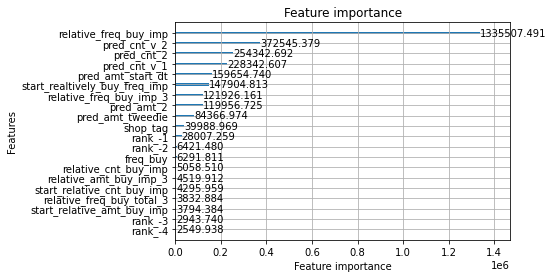

Training fold 2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.256646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5360
[LightGBM] [Info] Number of data points in the train set: 3555552, number of used features: 46
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@3: 0.842382	valid_1's ndcg@3: 0.928752
[100]	training's ndcg@3: 0.844876	valid_1's ndcg@3: 0.929032
[150]	training's ndcg@3: 0.846681	valid_1's ndcg@3: 0.929038
[200]	training's ndcg@3: 0.848308	valid_1's ndcg@3: 0.929039
Early stopping, best iteration is:
[183]	training's ndcg@3: 0.847767	valid_1's ndcg@3: 0.929085


<Figure size 864x432 with 0 Axes>

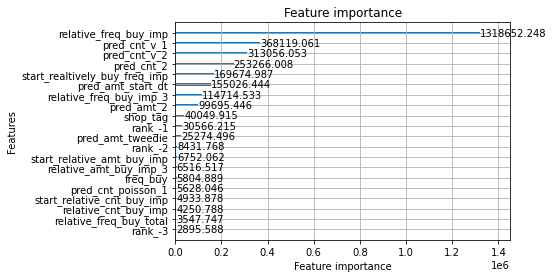

Training fold 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.188517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5363
[LightGBM] [Info] Number of data points in the train set: 3555552, number of used features: 46
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@3: 0.842687	valid_1's ndcg@3: 0.92854
[100]	training's ndcg@3: 0.845127	valid_1's ndcg@3: 0.928728
[150]	training's ndcg@3: 0.847012	valid_1's ndcg@3: 0.92881
[200]	training's ndcg@3: 0.848588	valid_1's ndcg@3: 0.928797
Early stopping, best iteration is:
[173]	training's ndcg@3: 0.847745	valid_1's ndcg@3: 0.928818


<Figure size 864x432 with 0 Axes>

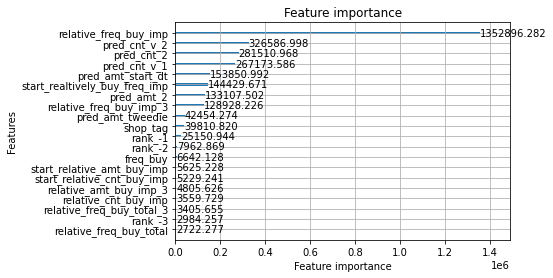

Training fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5363
[LightGBM] [Info] Number of data points in the train set: 3555552, number of used features: 46
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@3: 0.842709	valid_1's ndcg@3: 0.928999
[100]	training's ndcg@3: 0.845055	valid_1's ndcg@3: 0.929185
[150]	training's ndcg@3: 0.846982	valid_1's ndcg@3: 0.929239
Early stopping, best iteration is:
[140]	training's ndcg@3: 0.846648	valid_1's ndcg@3: 0.929289


<Figure size 864x432 with 0 Axes>

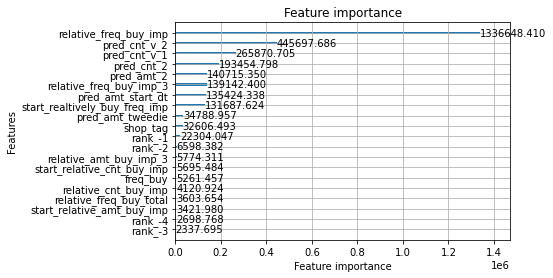

Training fold 2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.197410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5365
[LightGBM] [Info] Number of data points in the train set: 3555552, number of used features: 46
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@3: 0.842805	valid_1's ndcg@3: 0.928897
[100]	training's ndcg@3: 0.845212	valid_1's ndcg@3: 0.929176
[150]	training's ndcg@3: 0.847135	valid_1's ndcg@3: 0.929198
Early stopping, best iteration is:
[127]	training's ndcg@3: 0.846263	valid_1's ndcg@3: 0.929256


<Figure size 864x432 with 0 Axes>

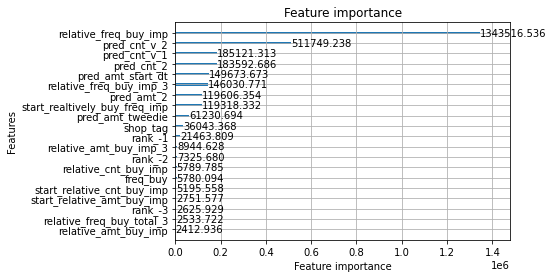

Training fold 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5359
[LightGBM] [Info] Number of data points in the train set: 3555552, number of used features: 46
Training until validation scores don't improve for 50 rounds
[50]	training's ndcg@3: 0.843017	valid_1's ndcg@3: 0.929158
[100]	training's ndcg@3: 0.845474	valid_1's ndcg@3: 0.929445
[150]	training's ndcg@3: 0.847362	valid_1's ndcg@3: 0.929434
Early stopping, best iteration is:
[131]	training's ndcg@3: 0.846688	valid_1's ndcg@3: 0.929494


<Figure size 864x432 with 0 Axes>

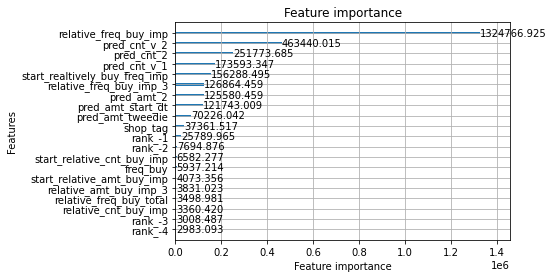

In [12]:
results = {}
for i in range(3):
    X = stack_handler.train_feats[i][use_cols].copy()
    y = stack_handler.ylabels[i].reset_index(drop='True').copy()

    df = pd.concat([y, X], axis=1)
    df = df.sort_values(by='query_id')

    gain_list = sorted(df['txn_amt'].unique())
    label_list = list(range(len(gain_list)))
    gain_to_label = {gain: label for label, gain in enumerate(gain_list)}

    df['txn_amt'] = df['txn_amt'].map(gain_to_label)
    df = pd.merge(df, rank_train, on=['query_id', 'shop_tag'], how='left')
    df = pd.merge(df, amt_train, on=['query_id', 'shop_tag'], how='left')
    df['shop_tag'] = df['shop_tag'].apply(lambda x: int(x))
    # df = df[~df['chid'].isin(miss_ids)]
    # zero_term = df[['query_id', 'txn_amt']].groupby('query_id').agg(lambda x: x.eq(0).sum()).reset_index()
    # use_query_ids = zero_term[zero_term['txn_amt']<=13]['query_id'].to_list()
    # df = df[df['query_id'].isin(use_query_ids)]
    df = df[['query_id', 'shop_tag'] + use_cols + rank_cols + freq_cols +
            ['txn_amt']]
    X = df[['shop_tag'] + use_cols + rank_cols + freq_cols].copy()
    y = df[['txn_amt']].copy()
    query_ids = df[['query_id']].copy()

    kf = KFold(n_splits=3, shuffle=True, random_state=16)
    kf.get_n_splits(X)

    params = {
        "boosting": 'gbrt',
        "objective": 'lambdarank',
        "metric": 'ndcg',
        "lambdarank_truncation_level": 3,
        "label_gain": gain_list,
        "ndcg_at": [3],
        # "tree_learner": 'voting',
        # "learning_rate" : 0.01,
        "min_data_in_leaf": 30,
        # 'verbose': 2,
    }

    preds = []
    for fold, (trn_ind, val_ind) in enumerate(kf.split(X)):
        print(f'Training fold {fold + 1}')

        X_train, X_val = X.iloc[trn_ind], X.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        qids_train = query_ids.iloc[trn_ind].groupby(
            "query_id")["query_id"].count().to_numpy()
        qids_validation = query_ids.iloc[val_ind].groupby(
            "query_id")["query_id"].count().to_numpy()
        train_item_dataset = lgb.Dataset(X_train,
                                         y_train,
                                         group=qids_train,
                                         categorical_feature=['shop_tag'] +
                                         rank_cols)
        val_item_dataset = lgb.Dataset(X_val,
                                       y_val,
                                       group=qids_validation,
                                       categorical_feature=['shop_tag'] +
                                       rank_cols)
        model = lgb.train(
            params=params,
            train_set=train_item_dataset,
            valid_sets=[train_item_dataset, val_item_dataset],
            num_boost_round=1000,
            early_stopping_rounds=50,
            verbose_eval=50,
        )
        plt.figure(figsize=(12, 6))
        lgb.plot_importance(model, max_num_features=20, importance_type='gain')
        plt.title("Feature importance")
        plt.show()
        test_feat = stack_handler.test_feats[i].copy()
        test_feat = pd.merge(test_feat,
                             rank_test,
                             on=['query_id', 'shop_tag'],
                             how='left')
        test_feat = pd.merge(test_feat,
                             amt_test,
                             on=['query_id', 'shop_tag'],
                             how='left')
        test_feat['shop_tag'] = test_feat['shop_tag'].apply(lambda x: int(x))
        # print(test_feat.head())
        pred = model.predict(test_feat[['shop_tag'] + use_cols + rank_cols +
                                       freq_cols])
        pred = pd.DataFrame({
            "chid": test_feat['chid'].to_list(),
            'shop_tag': test_feat['shop_tag'].to_list(),
            "query_id": test_feat['query_id'].to_list(),
            'pred': pred
        })
        preds.append(pred)
    preds_1 = preds[0].copy()
    preds_1['pred_2'] = preds[1]['pred'].to_list()
    preds_1['pred_3'] = preds[2]['pred'].to_list()
    preds_1['pred'] = preds_1[['pred', 'pred_2', 'pred_3']].mean(axis=1)
    preds_1 = preds_1.drop(['pred_2', 'pred_3'], axis=1)
    preds_1 = preds_1.pivot_table('pred', ['chid', 'query_id'],
                                  'shop_tag').reset_index()
    results.update({"Round{}".format(i + 1): preds_1})


In [13]:
# get preds averate for each cate 
mean_preds = {"chid": results['Round1']['chid'].to_list(),
              "query_id": results['Round1']['query_id'].to_list()}
for cate in stack_handler.required_cate:
    cate = int(cate)
    ru_1, ru_2, ru_3 = [results[ru][[cate]] for ru in ['Round1', 'Round2', 'Round3']]
    mean_value = pd.concat([ru_1, ru_2, ru_3], axis=1).mean(axis=1)
    mean_preds.update({cate: mean_value.to_list()})
    
mean_preds = pd.DataFrame(mean_preds)

In [14]:
result = mean_preds.copy()
result = result.drop('query_id', axis=1)
use_preds = result.iloc[:, 1:]
name_hashtable = list(use_preds.columns)
result = result[['chid']]
use_preds = use_preds.apply(lambda x: np.argsort(x), axis=1).iloc[:, -3:]
use_preds.columns = ['top3', 'top2', 'top1']
use_preds['chid'] = result['chid'].iloc[:500000].to_list()
use_preds = use_preds[['chid', 'top1', 'top2', 'top3']]
use_preds['top1'] = use_preds['top1'].apply(lambda x: name_hashtable[x])
use_preds['top2'] = use_preds['top2'].apply(lambda x: name_hashtable[x])
use_preds['top3'] = use_preds['top3'].apply(lambda x: name_hashtable[x])

In [15]:
sample = loader.load_data('sample.csv', data_type='csv')
submission = pd.merge(use_preds[['chid', 'top1', 'top2', 'top3']], sample[['chid']], on='chid', how='left')

In [16]:
submission['top1'].unique()

array([10, 48, 37, 22, 36,  2, 26, 15, 19,  6, 18, 12, 39, 13, 25, 21])

In [17]:
submission

,chid,top1,top2,top3
0,10000000,10,12,48
1,10000001,48,12,37
2,10000002,37,22,15
3,10000003,37,22,2
4,10000004,37,12,15
...,...,...,...,...
499995,10499995,10,2,37
499996,10499996,48,36,15
499997,10499997,36,48,25
499998,10499998,10,39,19


In [18]:
submission.to_csv('ltr_9_factors_rank_mean_vote_buy_freq_start_dt.csv', index=None)

In [19]:
pd.DataFrame({'Value':model.feature_importance('gain'),'Feature':X.columns}).sort_values(by='Value')

,Value,Feature
9,2.496336e+02,rank_-22
10,2.869661e+02,rank_-21
14,3.640187e+02,rank_-17
11,4.043508e+02,rank_-20
13,4.082667e+02,rank_-18
12,4.589613e+02,rank_-19
15,5.128082e+02,rank_-16
22,5.169878e+02,rank_-9
23,5.443850e+02,rank_-8
20,5.577073e+02,rank_-11


In [20]:
pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns}).sort_values(by='Value')

,Value,Feature
9,24,rank_-22
10,28,rank_-21
11,36,rank_-20
13,37,rank_-18
14,38,rank_-17
12,40,rank_-19
21,43,rank_-10
20,43,rank_-11
23,44,rank_-8
22,48,rank_-9


In [1]:
import gc
gc.collect()

232

In [22]:
import gc
gc.collect()

4